In [23]:
# Import dependencies
import os
import numpy as np
import wfdb
from pydub import AudioSegment
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
from scipy import fftpack

In [2]:
# Define constants

# Since audio data, need signed bit integer
# According to dataset: 32-bit
SIGNED_32BIT = 2**31 - 1

# Since 32-bit, 8bits/byte
SAMPLE_WIDTH = 4

## Import data

In [3]:
# Raw dataset file path
rawdata_path = "../resources/voiced_dataset/"

# Get all the files in the directory
files = os.listdir(rawdata_path)

# Create lists to check dataset
voice_info = []
voice_file = []
audio_file = []

# Loop through each file
for file in files:
    
    # Look through voice files only
    if file.startswith("voice"):
        
        # Isolate the info text files
        if file.endswith("-info.txt"):
            voice_id = file.split("-")[0]
            voice_info.append(voice_id)
        
        # Isolate the voice text files
        elif file.endswith(".txt"):
            voice_id = file.split(".")[0]
            voice_file.append(voice_id)
            
        # Isolate the audio files
        elif file.endswith(".hea"):
            voice_id = file.split(".")[0]
            audio_file.append(voice_id)

# Confirm each sample has a signal and info file
print(f'Info file: {len(set(voice_info))}')
print(f'Signal file: {len(set(voice_file))}')
print(f'Audio file: {len(set(audio_file))}')

Info file: 208
Signal file: 208
Audio file: 208


## Convert wfdb to wav

In [4]:
# Convert to a wav file
for file in tqdm(files, desc="Converting to wav"):
    
    # Extract .hea files only
    if file.startswith("voice") and file.endswith(".hea"):
        voice_id = file.split(".")[0]
        
        # Get the record name
        record_name = rawdata_path + voice_id
        
        # Read the wfdb record
        record = wfdb.rdrecord(record_name)
        
        # Get the signal data and sampling freq (fs)
        signal_data = record.p_signal
        fs = record.fs
        
        # Find the min and max of the signal data
        signal_min = np.min(signal_data)
        signal_max = np.max(signal_data)
        
        # Normalise and scale to 32-bit range
        shift_min = signal_data - signal_min
        scale_factor = signal_max - signal_min
        normalised_signal = shift_min / scale_factor
        normalised_signal = (SIGNED_32BIT * normalised_signal).astype(np.int32)
        
        # Create an AudioSegment from the normalised signal data
        audio_segment = AudioSegment(
            normalised_signal.tobytes(),
            frame_rate = fs,
            sample_width = SAMPLE_WIDTH,
            channels = 1 # mono, not stereo
        )
        
        # Save as a wav file
        output_filename = f'../resources/audio_files/{voice_id}.wav'
        audio_segment.export(output_filename, format='wav')

Converting to wav: 100%|████████████████████| 834/834 [00:00<00:00, 4550.14it/s]


## Display the Waveforms

In [7]:
# Retrieve the audio files
audio_path = "../resources/audio_files/"
audio_files = os.listdir(audio_path)

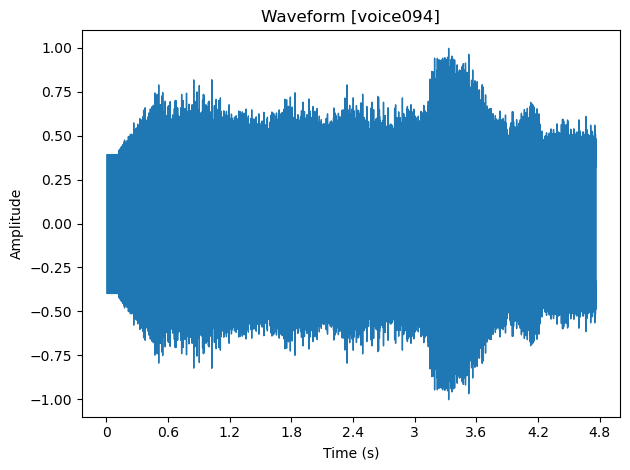

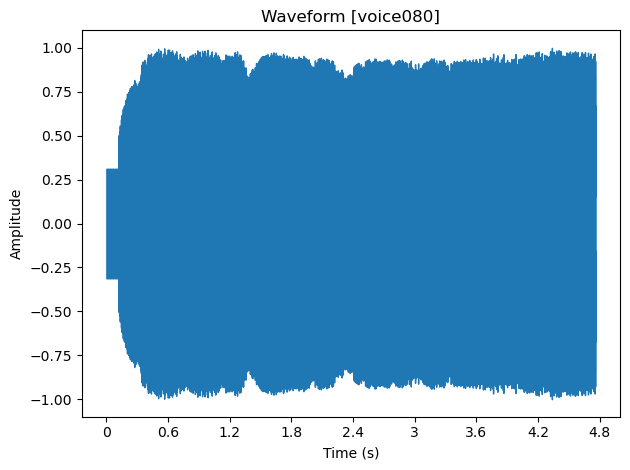

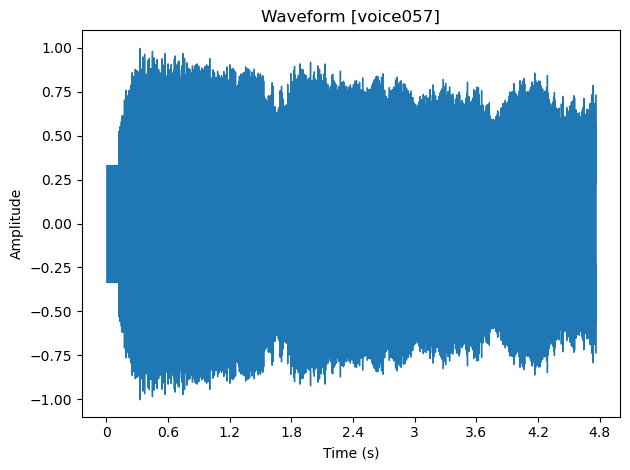

In [15]:
# Display the first 3 waveforms
for file in audio_files[:3]:
    
    # Load the file
    y, sr = librosa.load(
        audio_path + file, # full file path
        sr = None # preserve sampling rate
    )
    
    # Plot the waveform
    librosa.display.waveshow(y, sr=sr)
    
    # Add labels
    plt.title(f'Waveform [{file.split(".")[0]}]')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(f'../images/waveform_{file}.png', transparent=True)
    
    # Display the waveform
    plt.show()

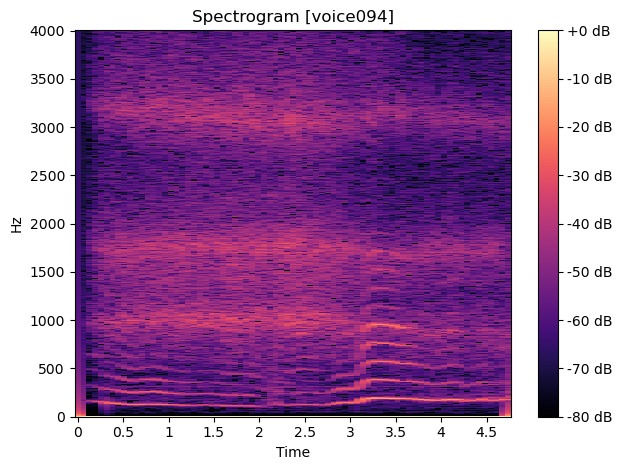

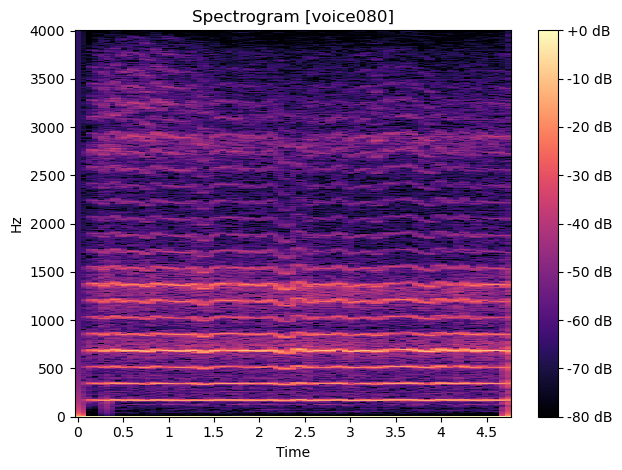

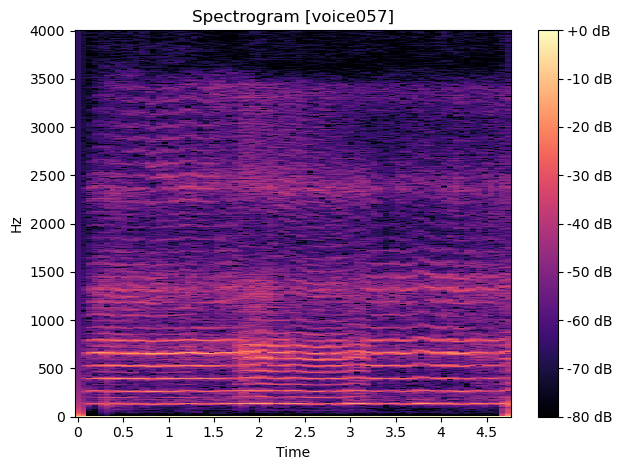

In [17]:
# Display the first 3 spectrograms
for file in audio_files[:3]:
    
    # Load the file
    y, sr = librosa.load(
        audio_path + file, # full file path
        sr = None # preserve sampling rate
    )
    
    # Plot the spectrogram
    D = librosa.amplitude_to_db(
        np.abs(librosa.stft(y)),
        ref = np.max
    )

    # Plot the spectrogram
    librosa.display.specshow(
        D,
        sr = sr,
        x_axis = 'time',
        y_axis = 'linear' # can also choose: linear
    )
    
    # Add labels
    plt.title(f'Spectrogram [{file.split(".")[0]}]')
    plt.colorbar(format='%+2.0f dB')
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(f'../images/spectrogram_{file}.png', transparent=True)
    
    plt.show()

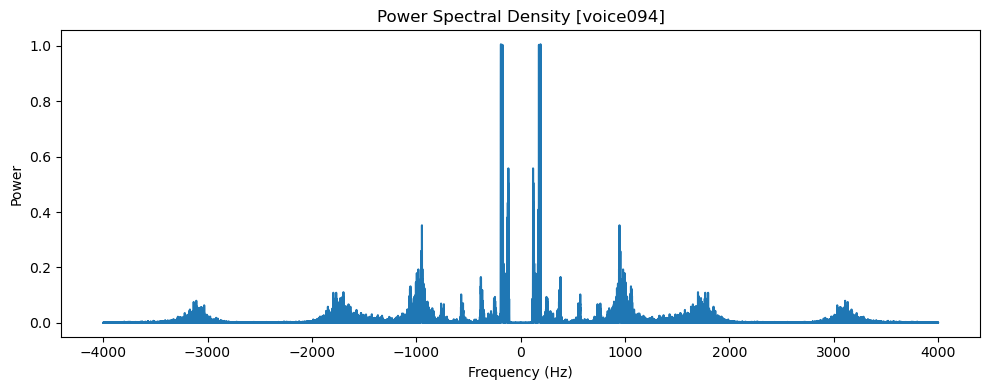

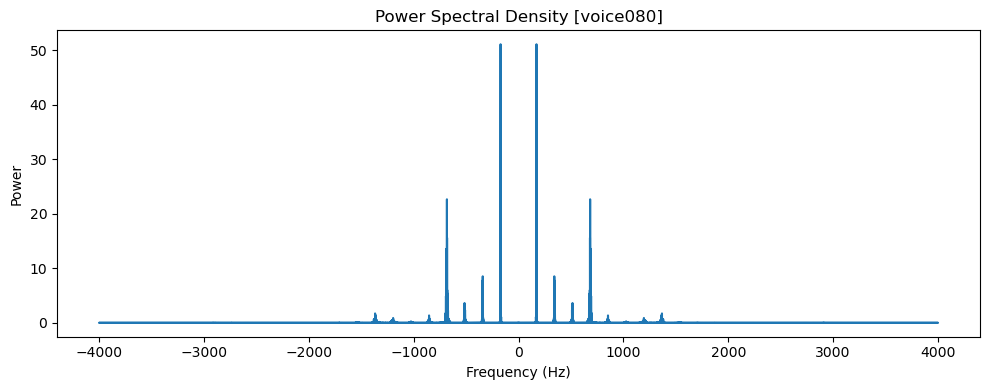

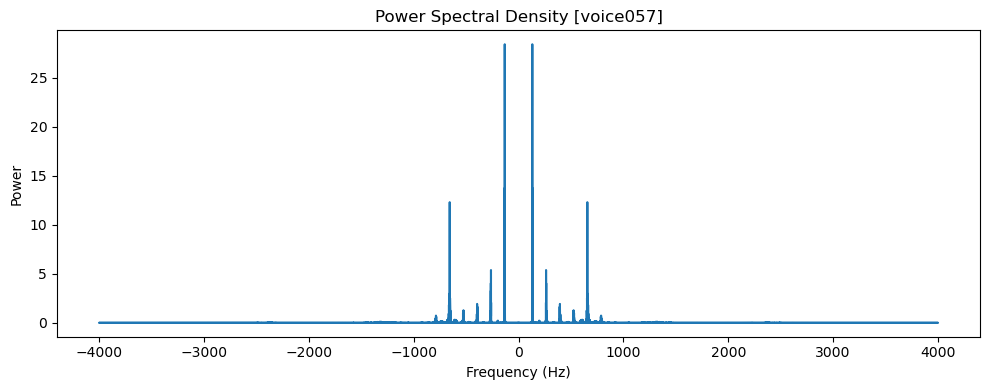

In [30]:
# Display the first 3 frequency plots (PSD)
for file in audio_files[:3]:
    
    # Load the file
    y, sr = librosa.load(
        audio_path + file, # full file path
        sr = None # preserve sampling rate
    )
    
    # Compute the FFT
    Y = fftpack.fft(y)

    # Compute the absolute value of the FFT
    abs_Y = np.abs(Y)

    # Compute the PSD
    psd = abs_Y ** 2 / len(y)

    # Compute the frequencies
    frequencies = fftpack.fftfreq(len(y), 1.0 / sr)

    # Ignore the first element (DC component)
    frequencies = frequencies[1:]
    psd = psd[1:]

    # Plot the PSD
    plt.figure(figsize=(10, 4))
    plt.plot(frequencies, psd)
    plt.title(f'Power Spectral Density [{file.split(".")[0]}]')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(f'../images/psd_{file}.png', transparent=True)
    
    plt.show()